# Racial Bias in Employment in the State of Pennsylvania

## Abstract:
In this blog, we are going to use ACS data to train a model to predict whether a person is emloyed or not give a list of features. Then, we will analyze the model to see if there is any racial bias in the employment prediction. Lastly, we will discuss the possible effects of this model if it was used in the real world.

In [2]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "PA"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000007,2,1,200,1,42,1013097,23,59,...,2,2,23,3,45,23,23,22,42,43
1,P,2018GQ0000009,2,1,3104,1,42,1013097,72,39,...,72,15,73,132,18,18,126,71,73,15
2,P,2018GQ0000010,2,1,803,1,42,1013097,31,18,...,31,30,32,30,31,4,32,59,5,59
3,P,2018GQ0000032,2,1,3501,1,42,1013097,92,20,...,93,14,13,16,89,95,90,90,93,13
4,P,2018GQ0000062,2,1,3302,1,42,1013097,23,20,...,43,4,22,22,23,3,22,41,22,3


In [3]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,59,16.0,1,16,1,NaN,1,3.0,4.0,4,1,2,2,2.0,2,1,6.0
1,39,16.0,5,16,1,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,6.0
2,18,16.0,5,17,2,NaN,2,1.0,4.0,1,1,2,2,2.0,2,1,6.0
3,20,19.0,5,17,2,NaN,1,3.0,4.0,4,1,2,2,2.0,2,1,6.0
4,20,19.0,5,17,2,NaN,1,3.0,4.0,4,1,2,2,2.0,2,9,1.0


In [4]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

In [5]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [8]:
y_hat = model.predict(X_test)

In [9]:
(y_hat == y_test).mean()

0.7860075927791121

In [10]:
(y_hat == y_test)[group_test == 1].mean()

0.787089618456078

In [11]:
(y_hat == y_test)[group_test == 2].mean()

0.7692307692307693

In [12]:
confusion_matrix(y_test, y_hat)

array([[10439,  3251],
       [ 2273,  9851]], dtype=int64)

In [13]:
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier(max_depth=5)
model2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [14]:
y2_hat = model2.predict(X_test)

In [15]:
(y2_hat == y_test).mean()

0.8241651816843574

In [16]:
(y2_hat == y_test)[group_test == 1].mean()

0.8258207630878438

In [17]:
(y2_hat == y_test)[group_test == 2].mean()

0.8094951923076923

In [18]:
confusion_matrix(y_test, y2_hat)

array([[11089,  2601],
       [ 1938, 10186]], dtype=int64)

# Basic Descriptives

In [19]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
df

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,43.0,16.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,1.0,1,True
1,3.0,1.0,5.0,15.0,2.0,0.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,0.0,1.0,1,False
2,47.0,11.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1,True
3,86.0,21.0,2.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1,False
4,50.0,16.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103247,43.0,12.0,5.0,13.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
103248,5.0,2.0,5.0,2.0,2.0,5.0,1.0,3.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1,False
103249,54.0,21.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,True
103250,15.0,12.0,5.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False


How many individuals are in the data?

In [20]:
df.shape[0]

103252

Of these individuals, what proportion have target label equal to 1? In employment prediction, these would correspond to individuals who are employed.

In [21]:
is_employed = df["label"] == True
is_employed.sum()

48096

Of these individuals, how many are in each of the groups?

In [22]:
is_employed_white = df[group_train == 1]["label"] == True
is_employed_white.sum()

42897

In [23]:
is_employed_black = df[group_train == 2]["label"] == True
is_employed_black.sum()

2585

In [24]:
is_employed_other = df[group_train >2]["label"] == True
is_employed_other.sum()

2614

In [25]:
is_employed_white.sum() + is_employed_black.sum() + is_employed_other.sum()

48096

In each group what proportion of individuals have target label equal to 1?

In [26]:
total_black = (group_train == 2).sum()
total_white = (group_train == 1).sum()
total_other = (group_train > 2).sum()

x = is_employed_white.sum() / total_white
y = is_employed_black.sum() / total_black
z = is_employed_other.sum() / total_other

txt = f"White: {x:.2%}, Black: {y:.2%}, Other: {z:.2%}"
txt

'White: 47.53%, Black: 38.27%, Other: 41.82%'

Check for intersectional trends by studying the proportion of positive target labels broken out by your chosen group labels and an addtional group label.

In [27]:
# is_female = df["SEX"] == 2
# is_male = df["SEX"] == 1

# ewm = df[is_male & is_employed_white].shape[0]
# ebm = df[is_employed_black & is_male].shape[0]
# ewf = df[is_employed_white & is_female].shape[0]
# ebf = df[is_employed_black & is_female].shape[0]

# employed_by_group = [ewm, ebm, ewf, ebf]


In [28]:
# total_white_m = df[is_male & (group_train == 1)].shape[0]
# total_black_m = df[is_male & (group_train == 2)].shape[0]
# total_white_f = df[is_female & (group_train == 1)].shape[0]
# total_black_f = df[is_female & (group_train == 2)].shape[0]

# total_by_group = [total_white_m, total_black_m, total_white_f, total_black_f]

# rate_by_group = [employed_by_group[i] / total_by_group[i] for i in range(4)]
# rate_by_group



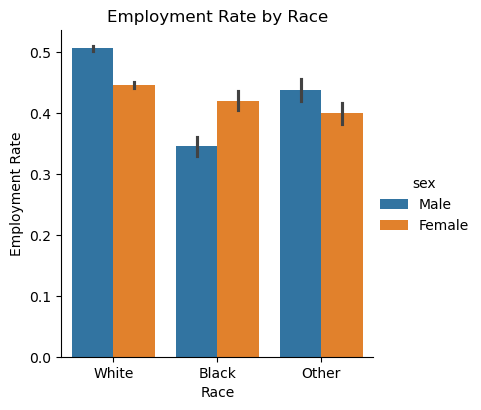

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

df["race"] = df["group"].apply(lambda x: "White" if x == 1 else ("Black" if x == 2 else "Other"))
df["sex"] = df["SEX"].apply(lambda x: "Male" if x == 1 else ("Female"))
sns.catplot(data=df, kind="bar", x="race", y="label", hue="sex", height=4, aspect=1).set_axis_labels("Race", "Employment Rate").set(title="Employment Rate by Race")
# sns.barplot(x=["White Male", "Black Male", "White Female", "Black Female"], y=rate_by_group)

# Auditing the Model
## Overall Measures
*What is the overall accuracy of your model?* : My best performing model was a Decision Tree Classifier with a max depth of 5. The following cells will calculate the accuracy of this model on test data. 

In [30]:
cm = confusion_matrix(y_test, y2_hat)
acc = (cm[0,0] + cm[1,1]) / cm.sum()
accuracy = f"The overall accuracy of the model is {acc:.2%}"
accuracy

'The overall accuracy of the model is 82.42%'

In [31]:
ppv = cm[1,1] / (cm[1,1] + cm[0,1])
pp_value = f"The positive predictive value of the model is {ppv:.2%}"
pp_value

'The positive predictive value of the model is 79.66%'

In [32]:
fnr = cm[1,0] / (cm[1,0] + cm[1,1])
fn_rate = f"The false negative rate of the model is {fnr:.2%}"
fn_rate

'The false negative rate of the model is 15.98%'

In [33]:
fpr = cm[0,1] / (cm[0,1] + cm[0,0])
fp_rate = f"The false positive rate of the model is {fpr:.2%}"
fp_rate

'The false positive rate of the model is 19.00%'

## Group Measures
*What is the accuracy of your model for each group?* : The following cells will calculate the accuracy of this model on test data for each group.

In [34]:
wcm = confusion_matrix(y_test[group_test == 1], y2_hat[group_test == 1])
wacc = (wcm[0,0] + wcm[1,1]) / wcm.sum()
waccuracy = f"The accuracy of the model for white people is {wacc:.2%}"
waccuracy

'The accuracy of the model for white people is 82.58%'

In [35]:
bcm = confusion_matrix(y_test[group_test == 2], y2_hat[group_test == 2])
bacc = (bcm[0,0] + bcm[1,1]) / bcm.sum()
baccuracy = f"The accuracy of the model for black people is {bacc:.2%}"
baccuracy

'The accuracy of the model for black people is 80.95%'

In [36]:
ocm = confusion_matrix(y_test[group_test > 2], y2_hat[group_test > 2])
oacc = (ocm[0,0] + ocm[1,1]) / ocm.sum()
oaccuracy = f"The accuracy of the model for other people is {oacc:.2%}"
oaccuracy

'The accuracy of the model for other people is 81.61%'

In the upcoming cells we will be calculating the positive predictive value (PPV) for each group.

In [37]:
wppv = wcm[1,1] / (wcm[1,1] + wcm[0,1])
wpp_value = f"The positive predictive value of the model for white people is {wppv:.2%}"
wpp_value

'The positive predictive value of the model for white people is 80.43%'

In [38]:
bppv = bcm[1,1] / (bcm[1,1] + bcm[0,1])
bpp_value = f"The positive predictive value of the model for black people is {bppv:.2%}"
bpp_value

'The positive predictive value of the model for black people is 72.16%'

In [39]:
oppv = ocm[1,1] / (ocm[1,1] + ocm[0,1])
opp_value = f"The positive predictive value of the model for other people is {oppv:.2%}"
opp_value

'The positive predictive value of the model for other people is 74.57%'

Next, we will calculate the false positive rate (FPR) and false negative rate (FNR) for each group.

In [40]:
wfnr = wcm[1,0] / (wcm[1,0] + wcm[1,1])
wfpr = wcm[0,1] / (wcm[0,1] + wcm[0,0])
wf_rates = f"The false negative rate of the model for white people is {wfnr:.2%} and the false positive rate is {wfpr:.2%}"
wf_rates

'The false negative rate of the model for white people is 15.67% and the false positive rate is 19.04%'

In [41]:
bfnr = bcm[1,0] / (bcm[1,0] + bcm[1,1])
bfpr = bcm[0,1] / (bcm[0,1] + bcm[0,0])
bf_rates = f"The false negative rate of the model for black people is {bfnr:.2%} and the false positive rate is {bfpr:.2%}"
bf_rates

'The false negative rate of the model for black people is 21.80% and the false positive rate is 17.46%'

In [42]:
ofnr = ocm[1,0] / (ocm[1,0] + ocm[1,1])
ofpr = ocm[0,1] / (ocm[0,1] + ocm[0,0])
of_rates = f"The false negative rate of the model for other people is {ofnr:.2%} and the false positive rate is {ofpr:.2%}"
of_rates

'The false negative rate of the model for other people is 15.79% and the false positive rate is 20.21%'

# Bias Measures
Next, we will see whether the error rates are balanced across groups. 

In [57]:
print(f'False Positive Rates \nWhite: {wfpr:.2%} \nBlack: {bfpr:.2%} \nOther: {ofpr:.2%}')

False Positive Rates 
White: 19.04% 
Black: 17.46% 
Other: 20.21%


Although the false positive rates are not equal across groups, they are not significantly different from each other. 

In [58]:
print(f'False Negative Rates \nWhite: {wfnr:.2%} \nBlack: {bfnr:.2%} \nOther: {ofnr:.2%}')

False Negative Rates 
White: 15.67% 
Black: 21.80% 
Other: 15.79%


The false negative rates of this model are substantially higher for black people than other groups. So we can conclude that his model does not satisfy approximate error rate balance.

# Concluding Discussion
What groups of people could benefit from a model that predicts employment status?
Banks, creit card companies, and landlords could all use this model as a too to predict trustworthiness of individuals to make payments.This holds a lot of weight because these groups give access to people's housing, credit, and other important resources that impact people's everyday lives.

Based on the bias audit, what could be the impact of deploying the model for large scale prediction in commercial and governmental settings?